# Lesson 3: Loading ML Models with Different Data Types

In this lab, you will load ML models in different datatypes.

- Load the Dummy Model from the helper file.
- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

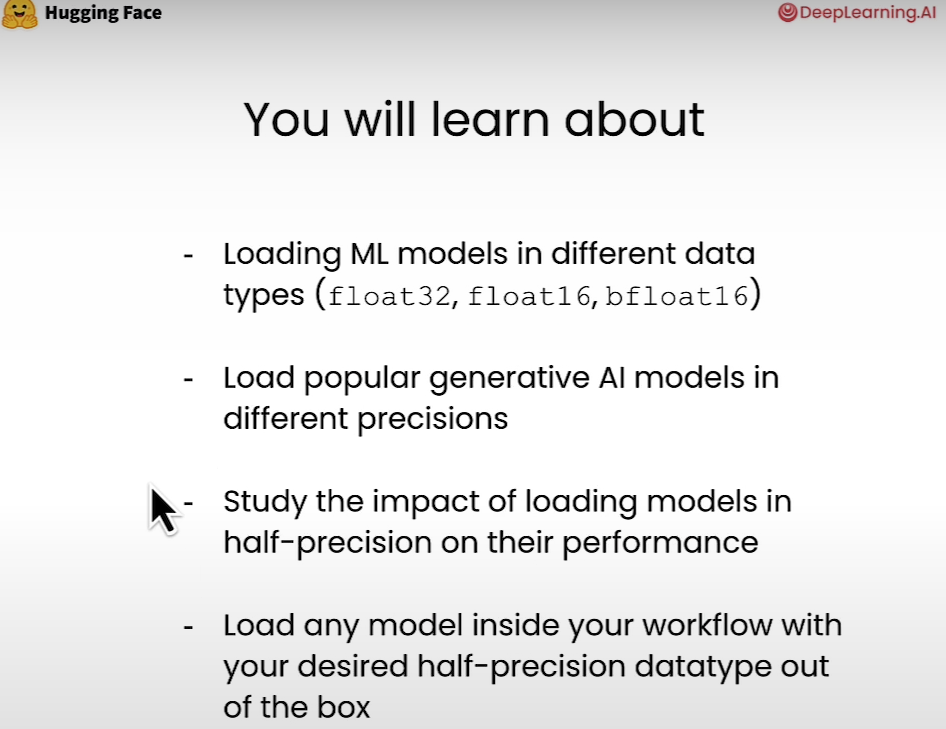

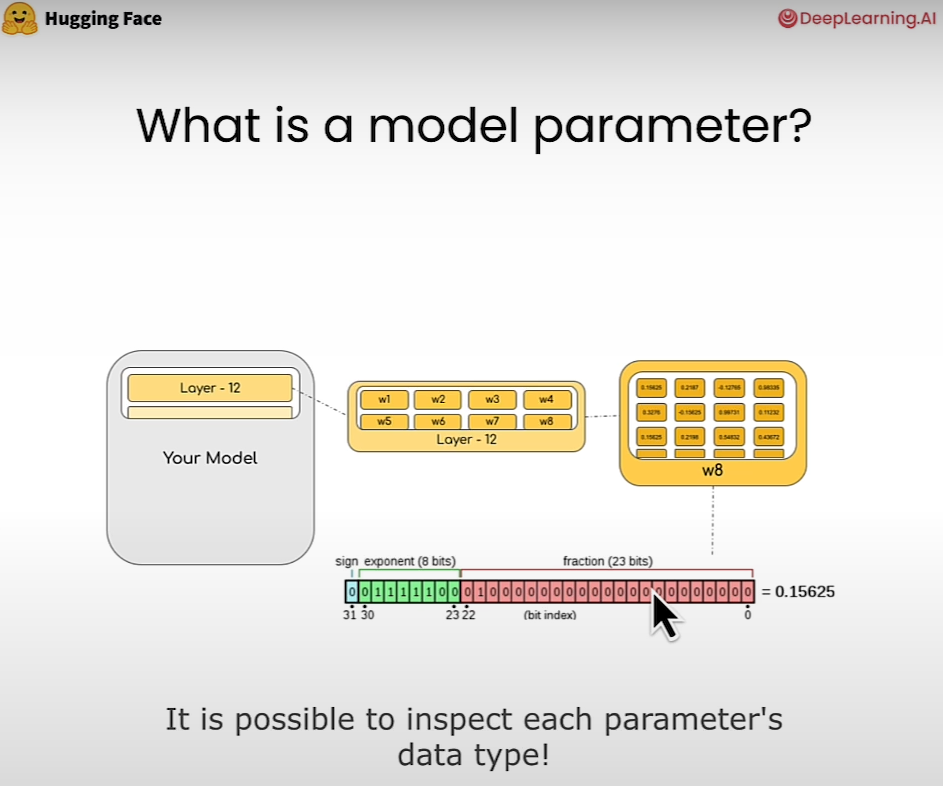

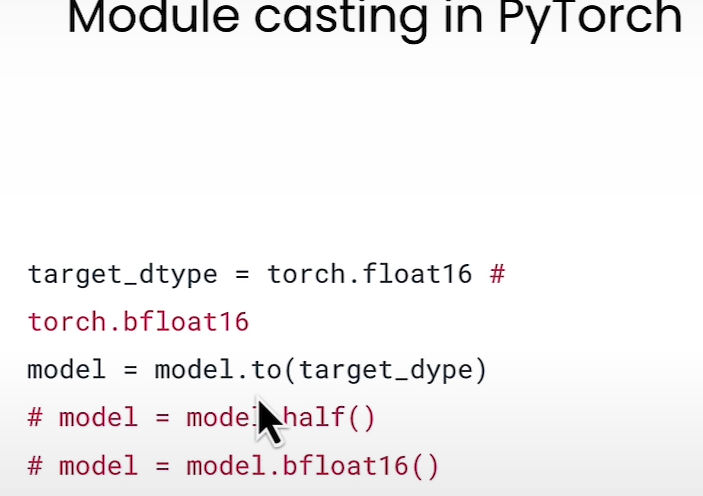


In [ ]:
#123456789#123456789#123456789#123456789#123456789#123456789#123456789

In [ ]:
from helper import DummyModel

In [ ]:
model = DummyModel()

In [ ]:
model

- Create a function to inspect the data types of the parameters in a model.

In [ ]:
def print_param_dtype(model):
    for name, param in model.named_parameters():
        print(f"{name} is loaded in {param.dtype}")

In [ ]:
print_param_dtype(model)

## Model Casting: `float16`

- Cast the model into a different precision.

In [ ]:
# float 16
model_fp16 = DummyModel().half()

- Inspect the data types of the parameters.

In [ ]:
print_param_dtype(model_fp16)

In [ ]:
model_fp16

- Run simple inference using model.

In [ ]:
import torch

In [ ]:
dummy_input = torch.LongTensor([[1, 0], [0, 1]])

In [ ]:
# inference using float32 model
logits_fp32 = model(dummy_input)

In [ ]:
logits_fp32

In [ ]:
# inference using float16 model
try:
    logits_fp16 = model_fp16(dummy_input)
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

## Model Casting: `bfloat16`

#### Note about deepcopy
- `copy.deepcopy` makes a copy of the model that is independent of the original.  Modifications you make to the copy will not affect the original, because you're making a "deep copy".  For more details, see the Python docs on the [copy][https://docs.python.org/3/library/copy.html] library.

In [ ]:
from copy import deepcopy

In [ ]:
model_bf16 = deepcopy(model)

In [ ]:
model_bf16 = model_bf16.to(torch.bfloat16)

In [ ]:
print_param_dtype(model_bf16)

In [ ]:
logits_bf16 = model_bf16(dummy_input)

- Now, compare the difference between `logits_fp32` and `logits_bf16`.

In [ ]:
mean_diff = torch.abs(logits_bf16 - logits_fp32).mean().item()
max_diff = torch.abs(logits_bf16 - logits_fp32).max().item()

print(f"Mean diff: {mean_diff} | Max diff: {max_diff}")

## Using Popular Generative Models in Different Data Types

- Load [Salesforce/blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) to perform image captioning.

#### To get the sample code that Younes showed:
- Click on the "Model Card" tab.
- On the right, click on the button "<> Use in Transformers", you'll see a popup with sample code for loading this model.

```Python
# Load model directly
from transformers import AutoProcessor, AutoModelForSeq2SeqLM

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/blip-image-captioning-base")
```

- To see the sample code with an example, click on "Read model documentation" at the bottom of the popup.  It opens a new tab.
  https://huggingface.co/docs/transformers/main/en/model_doc/blip#transformers.BlipForConditionalGeneration
- On this page, scroll down a bit, past the "parameters", section, and you'll see "Examples:"

```Python
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "A picture of"

inputs = processor(images=image, text=text, return_tensors="pt")

outputs = model(**inputs)
```

In [ ]:
from transformers import BlipForConditionalGeneration

In [ ]:
model_name = "Salesforce/blip-image-captioning-base"

In [ ]:
model = BlipForConditionalGeneration.from_pretrained(model_name)

In [ ]:
# inspect the default data types of the model

# print_param_dtype(model)

- Check the memory footprint of the model. 

In [ ]:
fp32_mem_footprint = model.get_memory_footprint()

In [ ]:
print("Footprint of the fp32 model in bytes: ",
      fp32_mem_footprint)
print("Footprint of the fp32 model in MBs: ", 
      fp32_mem_footprint/1e+6)

- Load the same model in `bfloat16`.

In [ ]:
model_bf16 = BlipForConditionalGeneration.from_pretrained(
                                               model_name,
                               torch_dtype=torch.bfloat16
)

In [ ]:
bf16_mem_footprint = model_bf16.get_memory_footprint()

In [ ]:
# Get the relative difference
relative_diff = bf16_mem_footprint / fp32_mem_footprint

print("Footprint of the bf16 model in MBs: ", 
      bf16_mem_footprint/1e+6)
print(f"Relative diff: {relative_diff}")

### Model Performance: `float32` vs `bfloat16`

- Now, compare the generation results of the two model.

In [ ]:
from transformers import BlipProcessor

In [ ]:
processor = BlipProcessor.from_pretrained(model_name)

- Load the image.

In [ ]:
from helper import load_image, get_generation
from IPython.display import display

img_url = 'https://storage.googleapis.com/\
sfr-vision-language-research/BLIP/demo.jpg'

image = load_image(img_url)
display(image.resize((500, 350)))

In [ ]:
results_fp32 = get_generation(model, 
                              processor, 
                              image, 
                              torch.float32)

In [ ]:
print("fp32 Model Results:\n", results_fp32)

In [ ]:
results_bf16 = get_generation(model_bf16, 
                              processor, 
                              image, 
                              torch.bfloat16)

In [ ]:
print("bf16 Model Results:\n", results_bf16)

### Default Data Type

- For Hugging Face Transformers library, the deafult data type to load the models in is `float32`
- You can set the "default data type" as what you want.

In [ ]:
desired_dtype = torch.bfloat16
torch.set_default_dtype(desired_dtype)

In [ ]:
dummy_model_bf16 = DummyModel()

In [ ]:
print_param_dtype(dummy_model_bf16)

- Similarly, you can reset the default data type to float32.

In [ ]:
torch.set_default_dtype(torch.float32)

In [ ]:
print_param_dtype(dummy_model_bf16)

### Note
- You just used a simple form of quantization, in which the model's parameters are saved in a more compact data type (bfloat16).  During inference, the model performs its calculations in this data type, and its activations are in this data type.
- In the next lesson, you will use another quantization method, "linear quantization", which enables the quantized model to maintain performance much closer to the original model by converting from the compressed data type back to the original FP32 data type during inference.